# 0 导入包环境
### python 环境 -- Python 3.8.1 ('py38': conda)

In [3]:
# from matplotlib.font_manager import FontManager
# fm = FontManager()
# mat_fonts = set(f.name for f in fm.ttflist)
# print(mat_fonts)

In [4]:
import math
import numpy as np
from scipy.stats import ncx2, chi2
import matplotlib.pyplot as plt
from pylab import *
# from sympy import *
from scipy import integrate
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # matplotlib 画图显示中文

# 1 设置参数

In [5]:
# 传输信噪比
pb = 16 # 传输功率，42dBm (30dBm=1w, +3dBm 功率*2) （基站的发射功率在数十瓦量级）
M_b = N_b = 2 # 均匀矩形阵列（URAS）参数 基站 默认2
M_i = N_i = 8 # 均匀矩形阵列（URAS）参数 IRS 默认8
# list_ni = [4, 5, 6, 7, 8, 9, 10, 11, 12] # 作变量时的取值
K_iu = 1 # 默认取值 # 莱斯信道参数
# list_kiu = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] # 作变量时的取值
A_bi = 2 # 路径损失系数（该系数越大，信号损失越大）BS-to-IRS
A_iu = 2.5 # 路径损失系数（该系数越大，信号损失越大 IRS-to-user
A_uu = 2 # 路径损失系数（该系数越大，信号损失越大）user-to-user
L_b = [0, 0, 20] # 基站、IRS、用户的位置 单位m，(使用 m，是因为参考论文中使用的m，并给出了响应的计算公式)
L_i = [100, 0, 20] # 基站、IRS、用户的位置 单位m，
L_u1 = [100, 20, 1] # 基站、IRS、用户的位置 单位m，
L_u2 = [100, 30, 1] # 基站、IRS、用户的位置 单位m，
ratio = 0.3333  # URAs 元件之间距离和波长之间的比值 （小于等于1 / 2），用于计算URAs的响应，最优相移不涉及该参数，随机相移的计算会用到
# 离开角、到达角
AoA_h_bi = AoA_v_bi = math.pi / 6
AoD_h_bi = AoD_v_bi = math.pi / 4
AoD_h_iu = AoD_v_iu = math.pi / 3
# 能量捕获过程
E_ec = 0.5 # RF-to-DC 的转化效率，（0.3-0.8)  参考论文默认是0.3
# 后向散射过程
P_ec = 0.625 # 进行能量转换的功率占总功率的比例(0~1) power of energy conversion 0.625
CU_b = 8.9e-6 # circuit threshold of backscatter  后向散射模式的最低电路门限 单位：w。8.9e-6
eff_b = 1 # 后向散射天线系数
R_b = 2.057 # outage rate of backscatter ， 后向散射中断概率 单位 bit/s/Hz，对应信载比门限5dB, 参考论文中只要高于阈值，就以预设的速率接收，预设速率是 1 kbps
# 主动传输过程
T_eh = 0.5 # time of energy harvestHTT模式中，能量捕获的时间占比，在该时间内全部的功率都用来进行能量转换
CU_a = 113e-6 # circuit threshold of active transmission(HTT) 主动传输模式的最低电路门限 单位：w， 113e-6
R_a = 7.213e-05 #4 outage rate of active transmission ， 主动传输中断概率 单位 bit/s/Hz， 对应信噪比门限-40dB
# 噪声
p_n = 9.99e-12 # power of noise 单位； w (=-80dBm)   
B = 1e6 # bandwidth 单位： Hz ，考虑单位带宽的情况，就不需要此项

# 计算函数
## URAs响应函数--随机相移计算需要

In [6]:
#  URA 响应函数 输入参数分别为：（到达或者离开URAs的）水平角、垂直角、URA行数、URA列数、阵列元间隔与信号波长的比值
def URAresponse(a1, a2, m, n, r):
    return 2 * math.pi * r * math.sin(a2) * ((m-1) * math.cos(a1) + (n-1) * math.sin(a1))

## 路径损失计算

In [7]:
# 计算公式来自元参考论文，计算结果随着距离的增加而减少， 输入参数分别为：路径损耗指数、位置1、位置2
def pathgain(a, d1, d2):
    # return 1 / (1000 * pow(np.sqrt(np.square(d1[0] - d2[0]) + np.square(d1[1] - d2[1])), a))
    return pow(np.sqrt(np.square(d1[0] - d2[0]) + np.square(d1[1] - d2[1]), np.square(d1[2] - d2[2])), -a) 

PL_bi = pathgain(A_bi, L_b, L_i)
PL_iu1 = pathgain(A_iu, L_i, L_u1)
PL_uu = pathgain(A_uu, L_u1, L_u2)
print('PL_bi, PL_iu1, PL_uu = ', PL_bi, PL_iu1, PL_uu)

PL_bi, PL_iu1, PL_uu =  0.0001 0.0005590169943749475 0.01


In [8]:
def pathloss(d): #D2D
    a = 148 + 40 * log10(d) # D2D yy
    a_1 = 126.1 + 37.6 * log10(d) # BS-to-user yy
    a_2 = 128 + 48 * log10(d)
    b = pow(10, - a / 10)
    b_1 = pow(10, - a_1 / 10)
    return a, b, b_1
a = pathloss(0.03)
print(a)

(87.0848501887865, 1.956658262297665e-09, 1.306243319195649e-07)


## 最优相移情况下，输入参数计算

In [9]:
P_l =  (PL_bi * PL_iu1 * K_iu * M_b * N_b * M_i * N_i * M_i * N_i) / (K_iu + 1) 
P_nl = PL_bi * PL_iu1 * M_b * N_b * M_i * N_i / (K_iu + 1) 
print("P_l, P_nl = ", P_l, P_nl)

P_l, P_nl =  0.00045794672179195697 7.155417527999328e-06


## 随机相移响应计算

In [10]:
# Random phase shifts 随机相移， 输入参数为：URA行数、URA列数、iu离开水平角、iu离开垂直角、bi到达水平角、bi到达垂直角；输出：多个复数和的模方
# 最优相移相移是一个实数，（即一个复数的模方），随机相移的响应也是如此
def random_phase(M, N, dhiu, dviu, ahbi, avbi):
    sum_x = 0
    sum_y = 0
    np.random.seed(3)
    for m in range(M):
       for n in range(N):
           phare_0 = np.random.uniform(0, 2*math.pi) #随机相移
           phare_1 = URAresponse(dhiu, dviu, m+1, n+1, ratio) - URAresponse(ahbi, avbi, m+1, n+1, ratio) + phare_0
           sum_x = sum_x + math.sin(phare_1) # 实部
           sum_y = sum_y + math.cos(phare_1) # 虚部
    # return pow(sum_x, 2) + pow(sum_y, 2), sum_x, sum_y # 模的平方，替代最优相移的 M_i * N_i * M_i * N_i
    return pow(sum_x, 2) + pow(sum_y, 2) # 模的平方，替代最优相移的 M_i * N_i * M_i * N_i
# print('random phare = ', a[0], random_phase(M_i, N_i, AoD_h_iu, AoD_v_iu, AoA_h_bi, AoA_v_bi)[1])

In [11]:
a = random_phase(M_i, N_i, AoD_h_iu, AoD_v_iu, AoA_h_bi, AoA_v_bi)
print(a)

120.36506854371032


## 随机相移情况下，输入参数计算

In [12]:
P_l_random = PL_bi * PL_iu1 * K_iu * M_b * N_b * random_phase(M_i, N_i, AoD_h_iu, AoD_v_iu, AoA_h_bi, AoA_v_bi) / (K_iu + 1) 
P_nl_random = PL_bi * PL_iu1 * M_b * N_b * M_i * N_i / (K_iu + 1) 
print("P_l_random, P_nl_random=", P_l_random, P_nl_random)

P_l_random, P_nl_random= 1.3457223769007896e-05 7.155417527999328e-06


## 非中心卡方分布输入参数计算
### 自由度(degrees of freedom) 非中心参数(non-centrality parameter) 阈值(threshold)

In [13]:
df = 2
def NC(pl, pn):
    return 2 * pl / pn
nc = NC(P_l, P_nl)
nc_random = NC(P_l_random, P_nl_random)
print("nc, nc_random =", nc, nc_random)
# 阈值threshold计算函数，输入参数：中断值r，参数P_nl，输出：阈值


nc, nc_random = 128.0 3.7614083919909476


## 两种模式下中断的发射功率的平均值

-0.0004549733608959785 -0.00017173002067198386
-0.000226 0.0
2.9733608959784936e-06 0.00017173002067198386
0.00023194672179195698 0.0003434600413439677
0.00046092008268793546 0.0005151900620159516
0.000689893443583914 0.0006869200826879354
0.0009188668044798925 0.0008586501033599193
0.0011478401653758708 0.0010303801240319032
0.0013768135262718494 0.001202110144703887
0.0016057868871678278 0.0013738401653758709


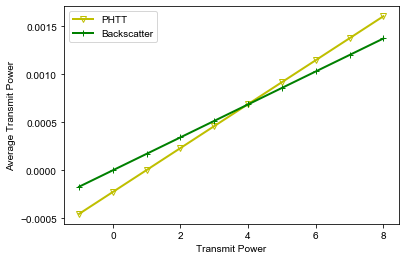

In [14]:
pbb = -1
ave_trans_a_array = []
ave_trans_b_array = []
pbb_array = []
for i in range(10):
    average_transmit_power_a = ( T_eh * E_ec * pbb * (nc * P_nl / 2) - CU_a) / (1 - T_eh)
    average_transmit_power_b =  eff_b * ( 1 - P_ec) * pbb * (nc * P_nl / 2)
    # print(average_transmit_power_a, average_transmit_power_b)
    ave_trans_a_array.append(average_transmit_power_a)
    ave_trans_b_array.append(average_transmit_power_b)
    pbb_array.append(pbb)
    pbb = pbb + 1
figure(1)
plt.plot(pbb_array, ave_trans_a_array, 'y-', marker='v', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1, label='PHTT')
plt.plot(pbb_array, ave_trans_b_array, 'g-', marker='+', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1, label='Backscatter')
plt.xlabel('Transmit Power')
plt.ylabel('Average Transmit Power')
plt.legend(loc='best', fancybox=True, shadow=False, frameon=True)

- 初始阈值计算：**模式选择、能量中断、覆盖**

In [88]:
def r_mode(CU_a, T_eh, E_ec, eff_b, P_ec, pb): # 两种模式下 速率比较的临界值
    return CU_a / ((T_eh * E_ec -  eff_b * (1 - T_eh) * (1 - P_ec)) * pb) 

def r_b_energy(CU_b, P_ec, E_ec, pb): # 后向散射模式下 能量中断的阈值
    return CU_b / (P_ec * E_ec * pb)
def r_htt_enerty(CU_a, T_eh, E_ec, pb): # 主动传输模式下，能量中断的阈值
    return CU_a / (T_eh * E_ec * pb)

def r_b_coverage(R_b, p_n, eff_b, P_ec, PL_uu, CU_b, E_ec, pb): # 后向散射模式下，覆盖中断的阈值 （是否满足最低接收信噪比）
    a = ((pow(2, R_b) - 1) * p_n) / (eff_b * (1 - P_ec) * pb * PL_uu) #路径损耗是否要平方？？？
    # a = ((pow(2, R_b) - 1) * p_n) / (eff_b * (1 - P_ec) * pb * PL_uu * PL_uu) #路径损耗是否要平方？？？
    b = CU_b / (P_ec * E_ec * pb)
    return max(a, b)
def r_htt_coverage(R_a, T_eh, p_n, PL_uu,  CU_a,  E_ec, pb): # 主动传输模式下，覆盖中断的阈值（是否满足最低接收信噪比）
    a = ((pow(2, R_a) - 1) * (1 - T_eh) * p_n + CU_a * PL_uu ) / (T_eh * E_ec * pb * PL_uu) #路径损耗是否要平方？？？
    # a = ((pow(2, R_a) - 1) * (1 - T_eh) * p_n + CU_a * PL_uu ) / (T_eh * E_ec * pb * PL_uu * PL_uu) #路径损耗是否要平方？？？
    b = CU_a / (T_eh * E_ec * pb)
    return max(a, b) 

- 输入阈值计算：非中心卡方分布的CDF

In [89]:
def threshold(r, pnl):
    return 2 * r / pnl


## 能量中断概率 VS 基站传输功率

## 模式选择概率 阈值曲线

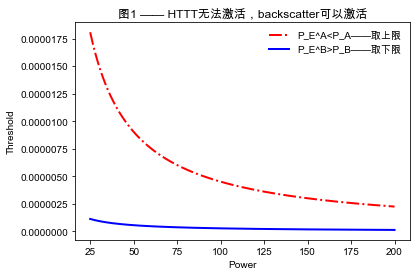

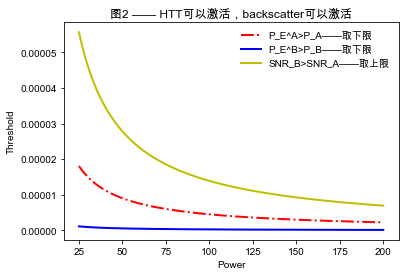

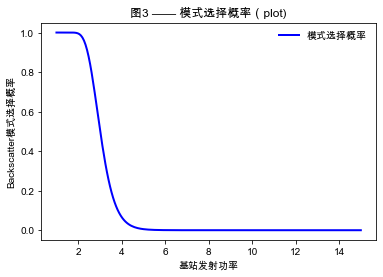

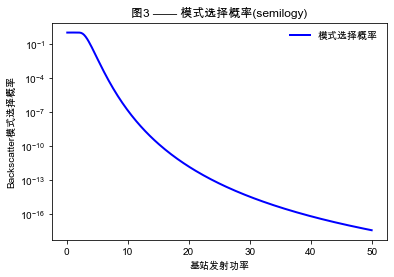

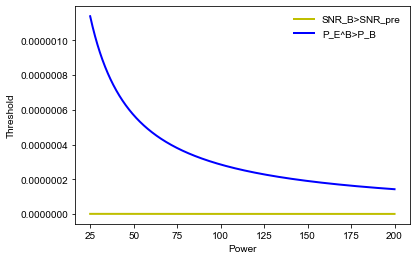

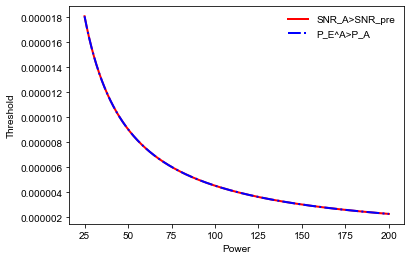

In [90]:
# 数据归一化 x' = atan(x) * 2 / pi
# 由图1和图2可以看出来条件最终结果的区间就是  P_E^B>P_B ，SNR_B>SNR_A
fig, ax = plt.subplots(1, 1)
x = np.linspace(25, 200, 1000)
plt.title("图1 —— HTTT无法激活，backscatter可以激活")
ax.plot(x, CU_a / (T_eh * E_ec * x), 'r-.', lw=2, alpha=1, label='P_E^A<P_A——取上限')
ax.plot(x, CU_b / (P_ec * E_ec * x), 'b-', lw=2, alpha=1, label='P_E^B>P_B——取下限')
plt.xlabel('Power')
plt.ylabel('Threshold')
ax.legend(loc='best', frameon=False)

fig, ax = plt.subplots(1, 1)
x = np.linspace(25, 200, 1000)
plt.title("图2 —— HTT可以激活，backscatter可以激活")
ax.plot(x, CU_a / (T_eh * E_ec * x), 'r-.', lw=2, alpha=1, label='P_E^A>P_A——取下限')
ax.plot(x, CU_b / (P_ec * E_ec * x), 'b-', lw=2, alpha=1, label='P_E^B>P_B——取下限')
ax.plot(x, (CU_a / ((T_eh * E_ec -  eff_b * (1 - T_eh) * (1 - P_ec)) * x)), 'y-', lw=2, alpha=1, label='SNR_B>SNR_A——取上限')
plt.xlabel('Power')
plt.ylabel('Threshold')
ax.legend(loc='best', frameon=False)

fig, ax = plt.subplots(1, 1)
x = np.linspace(1, 15, 200)
y_down = threshold(r_b_energy(CU_b, P_ec, E_ec, x), P_nl)
y_up = threshold(r_mode(CU_a, T_eh, E_ec, eff_b, P_ec, x), P_nl)
plt.title("图3 —— 模式选择概率（plot)")
ax.plot(x, ncx2.cdf(y_up, df, nc, loc=0, scale=1) - ncx2.cdf(y_down, df, nc, loc=0, scale=1), 'b-', lw=2, alpha=1, label='模式选择概率')
plt.xlabel('基站发射功率')
plt.ylabel('Backscatter模式选择概率')
ax.legend(loc='best', frameon=False)

figure(5)
x = np.linspace(0.1, 50, 200)
y_down = threshold(r_b_energy(CU_b, P_ec, E_ec, x), P_nl)
y_up = threshold(r_mode(CU_a, T_eh, E_ec, eff_b, P_ec, x), P_nl)
plt.title("图3 —— 模式选择概率(semilogy)")
semilogy(x, ncx2.cdf(y_up, df, nc, loc=0, scale=1) - ncx2.cdf(y_down, df, nc, loc=0, scale=1), 'b-', lw=2, alpha=1, label='模式选择概率')
plt.xlabel('基站发射功率')
plt.ylabel('Backscatter模式选择概率')
plt.legend(loc='best', frameon=False)
# prob_mode = ncx2.cdf(x_m, df, nc, loc=0, scale=1) - ncx2.cdf(x_c_b, df, nc, loc=0, scale=1)


fig, ax = plt.subplots(1, 1)
x = np.linspace(25, 200, 1000)
# ax.plot(x, (CU_a / ((T_eh * E_ec -  eff_b * (1 - T_eh) * (1 - P_ec)) * x)), 'r-', lw=2, alpha=1, label='SNR_B>SNR_A')
ax.plot(x, ((pow(2, R_b) - 1) * p_n) / (eff_b * (1 - P_ec) * x * PL_uu), 'y-', lw=2, alpha=1, label='SNR_B>SNR_pre')
ax.plot(x, CU_b / (P_ec * E_ec * x), 'b-', lw=2, alpha=1, label='P_E^B>P_B')
plt.xlabel('Power')
plt.ylabel('Threshold')
ax.legend(loc='best', frameon=False)




# 从图上可以看出，模式概率中的三个条件，只要满足 SNR_B>SNR_A 和 P_E^B>P_B，就能满足三个条件
# 只要能满足P_E^B>P_B，就能满足SNR_B>SNR_pre， 现在的情况是，在后向散射模式下，只要电路能启动，一定能满足backscatter的信噪比要求
fig, ax = plt.subplots(1, 1)
x = np.linspace(25, 200, 1000)
# ax.plot(x, , 'r-', lw=2, alpha=1, label='SNR_B>SNR_A')
ax.plot(x, ((pow(2, R_a) - 1) * (1 - T_eh) * p_n + CU_a * PL_uu ) / (T_eh * E_ec * x * PL_uu), 'r-', lw=2, alpha=1, label='SNR_A>SNR_pre')
ax.plot(x, CU_a / (T_eh * E_ec * x), 'b-.', lw=2, alpha=1, label='P_E^A>P_A')
plt.xlabel('Power')
plt.ylabel('Threshold')
ax.legend(loc='best', frameon=False)
# 这两条曲线非常接近


In [91]:
print("+3dB，功率x2,即10*log10(2)=", 10*log10(2), '\n', "+10dB，功率x10,即10*log10(10)=", 10*log10(10))

+3dB，功率x2,即10*log10(2)= 3.010299956639812 
 +10dB，功率x10,即10*log10(10)= 10.0


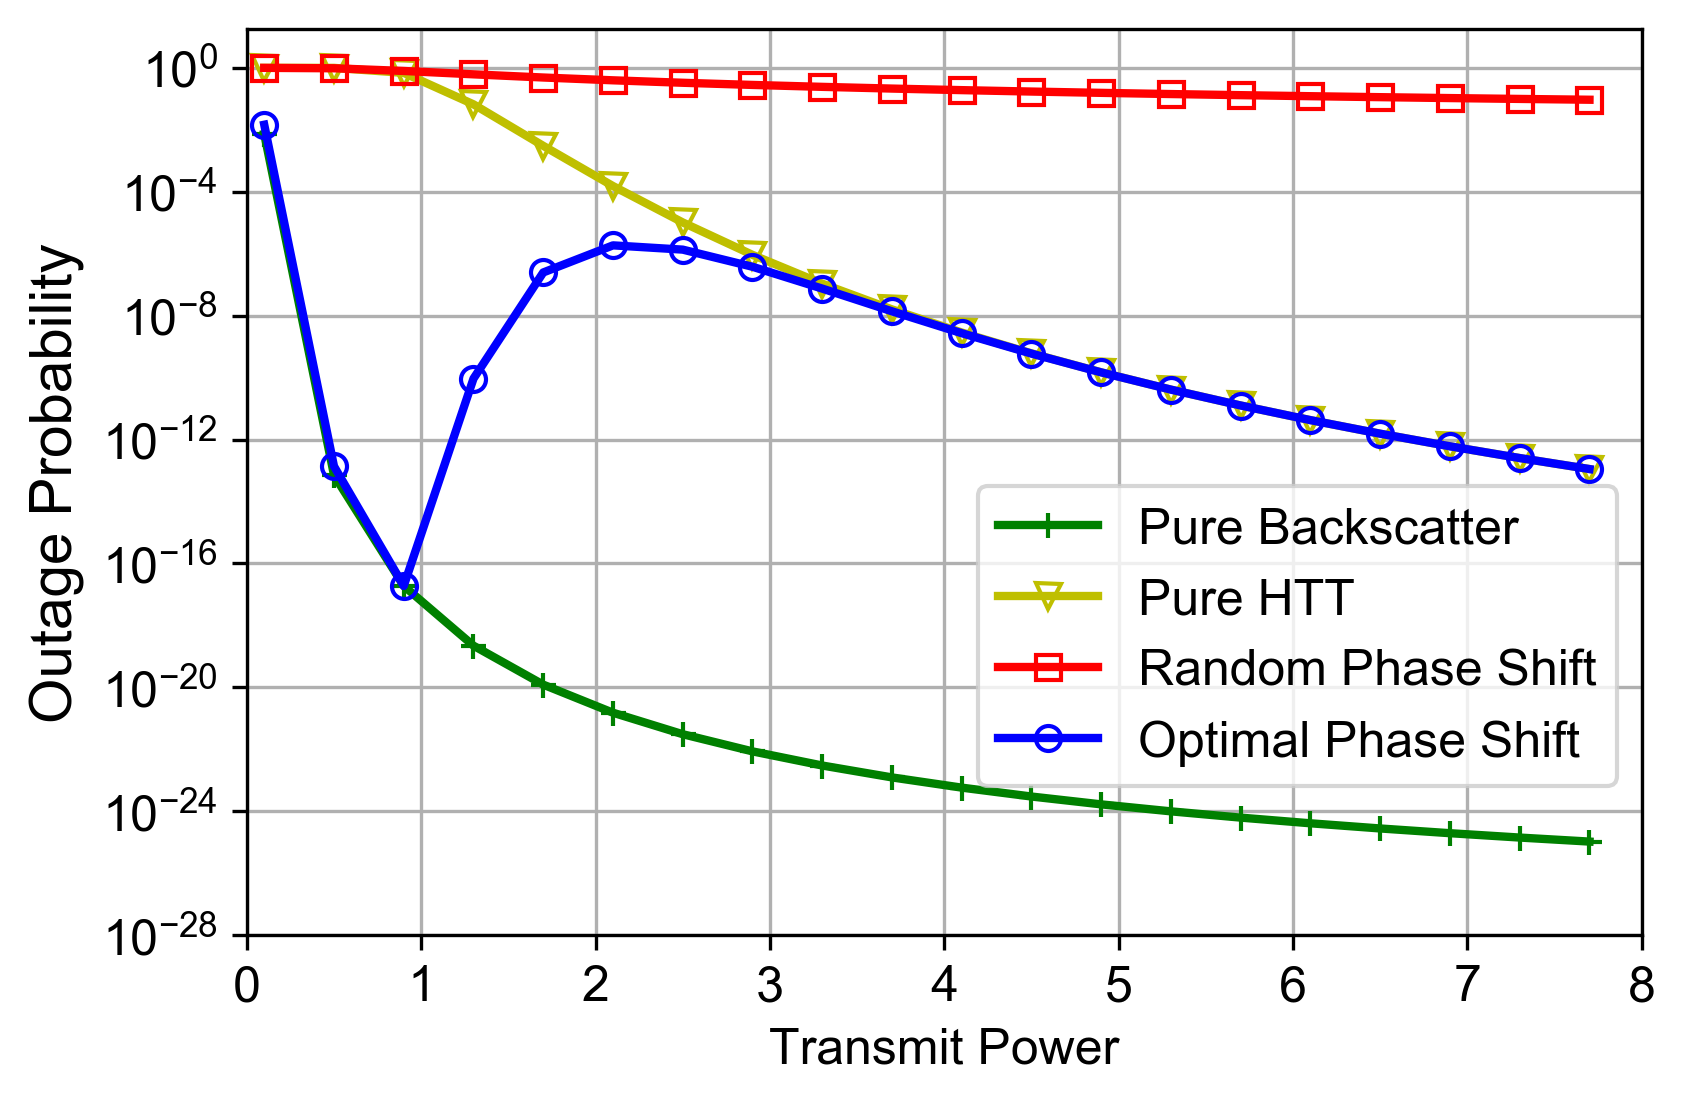

In [172]:
# 数组存储中断概率
b_prob_array = [] 
b_prob_random_array = [] 
a_prob_array = []
a_prob_random_array = []
o_prob_array = []
o_prob_random_array = []
o_prob_pure_a_array = []
o_prob_pure_b_array = []
# 数组存储传输功率
pb_array = []
# 数组存储backscatter模式选择概率
prob_mode_array = []
prob_mode_random_array = []
# 初始传输功率
pb = 0.1
# x_rmode = 0.05
for i in range(20):
    # 非中心参数
    nc = NC(P_l, P_nl)
    nc_random = NC(P_l_random, P_nl_random)
    # backscatter mode 能量中断阈值 （初始阈值 + CDF阈值）
    r_b = r_b_energy(CU_b, P_ec, E_ec, pb) #初始阈值
    x_b = threshold(r_b, P_nl) #CDF阈值-最优相移
    x_b_random = threshold(r_b, P_nl_random) # CDF随机相移
    # HTT mode 能量中断阈值 （初始阈值 + CDF阈值）
    r_a = r_htt_enerty(CU_a, T_eh, E_ec, pb) 
    x_a = threshold(r_a, P_nl)
    x_a_random = threshold(r_a, P_nl_random)
    # backscatter 模式能量中断概率 （最优相移 + 随机相移）
    b_prob = ncx2.cdf(x_b, df, nc, loc=0, scale=1) 
    b_prob_array.append(b_prob)
    b_prob_random = ncx2.cdf(x_b_random, df, nc_random, loc=0, scale=1) 
    b_prob_random_array.append(b_prob_random)
    # HTT 模式 能量中断概率 （最优相移 + 随机相移）
    a_prob = ncx2.cdf(x_a, df, nc, loc=0, scale=1)
    a_prob_array.append(a_prob)
    a_prob_random = ncx2.cdf(x_a_random, df, nc_random, loc=0, scale=1) 
    a_prob_random_array.append(a_prob_random)
    # 模式选择的阈值 （初始阈值 + CDF阈值）
    r_m = r_mode(CU_a, T_eh, E_ec, eff_b, P_ec, pb)
    x_m = threshold(r_m, P_nl)
    x_m_random = threshold(r_m, P_nl_random) # x_rmode_random 和 x_rmode 是相等的，输入参数都一样


    if x_b <= x_m:
        prob_mode = ncx2.cdf(x_m, df, nc, loc=0, scale=1) - ncx2.cdf(x_b, df, nc, loc=0, scale=1)
    else:
        prob_mode = 0
    if prob_mode > 1: # 防止概率超过1，导致后面的计算出现负值
        prob_mode = 1
    prob_mode_array.append(prob_mode)
    if x_b_random <= x_m_random:
        prob_mode_random = ncx2.cdf(x_m_random, df, nc_random, loc=0, scale=1) - ncx2.cdf(x_b_random, df, nc, loc=0, scale=1)
    else:
        prob_mode_random = 0
    if prob_mode_random > 1: # 防止概率超过1，导致后面的计算出现负值
        prob_mode_random = 1

    # 能量中断概率-最优
    o_prob = prob_mode * b_prob + (1 - prob_mode) * a_prob
    o_prob_array.append(o_prob)
    # 随机
    o_prob_random = prob_mode_random * b_prob_random + (1 - prob_mode_random) * a_prob_random
    o_prob_random_array.append(o_prob_random)
    # print('pb= ', pb, 'r_m= ', r_m, 'x_m= ', x_m, 'p_mode= ', prob_mode)
    # print( o_prob, '=', prob_mode, '*', b_prob, '+', '(1 -', prob_mode, ') *', a_prob, '\n')
    # 纯HTT
    o_prob_pure_a = a_prob
    o_prob_pure_a_array.append(o_prob_pure_a)
    # 纯后向散射
    o_prob_pure_b = b_prob
    o_prob_pure_b_array.append(o_prob_pure_b)
    # 传输概率
    pb_array.append(pb)
    pb = pb + 0.4
# figure(1) 
figure(1, dpi=300)

# plt.title('Outage probability versus Transmit Power')
# semilogy(pb_array, prob_mode_array, 'b-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1,  label='模式选择概率')
semilogy(pb_array, o_prob_pure_b_array, 'g-', marker='+', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1, label='Pure Backscatter')
semilogy(pb_array, o_prob_pure_a_array, 'y-', marker='v', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1, label='Pure HTT')
semilogy(pb_array, o_prob_random_array, 'r-', marker='s', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1, label='Random Phase Shift')
semilogy(pb_array, o_prob_array, 'b-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1, label='Optimal Phase Shift')

# plt.axis('square')

plt.yscale('log')
plt.grid(True)
plt.xlim(0, 8)
plt.ylim(10**(-28), 0)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.xlabel('Transmit Power', fontsize=12)
plt.ylabel('Outage Probability', fontsize=14)
plt.legend(loc='center right', bbox_to_anchor=(1, 0.33), fancybox=True, shadow=False, frameon=True,fontsize=12)


In [93]:
print(P_l, P_nl)

0.00045794672179195697 7.155417527999328e-06


## 覆盖概率 VS 基站发射功率 

[0.00294497236938418, 0.018025521064423344, 0.06390377261189495, 0.1546401084193354, 0.2857439282171874, 0.43611413680500755, 0.5814654274550995, 0.7051645575231145, 0.8008887408252373, 0.8698882203852714, 0.9170644862296687, 0.9480849649139368, 0.9679098819973383, 0.9803250148500703, 0.987991771517155, 0.9926834444804832, 0.9955395029915346, 0.9972742437122307, 0.9983280281018052, 0.9989694118120936]
[8.672862252242272e-06, 0.00032491940963990296, 0.004083692154029096, 0.02391356313194089, 0.08164959251298735, 0.1901955403211763, 0.33810204332554233, 0.49725705318677155, 0.6414227751806366, 0.7567055159650575, 0.8410072719036898, 0.8988651006958646, 0.9368495396681054, 0.9610371347407946, 0.9761277405856104, 0.9854204209456408, 0.991098902016636, 0.9945559171718059, 0.996658851693643, 0.9979398857362045]


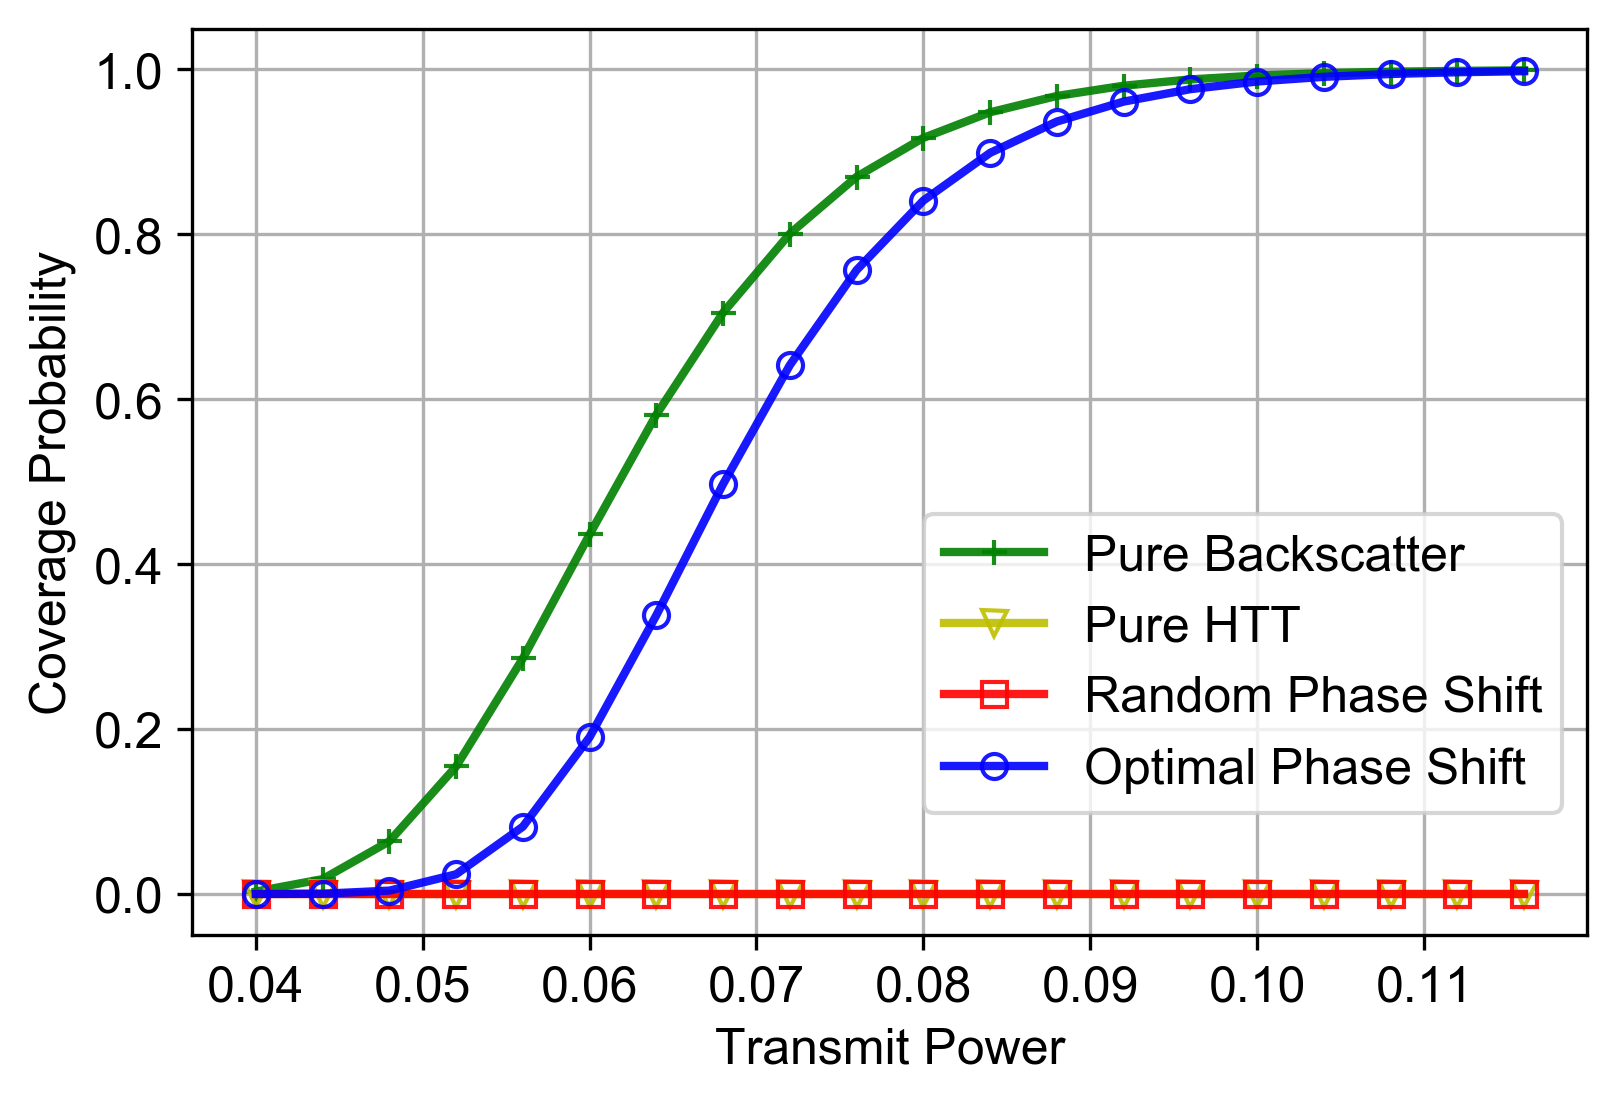

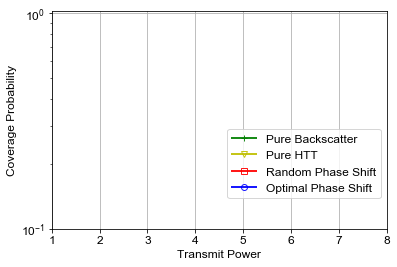

In [162]:
# 数组存储覆盖概率
c_prob_array = []
c_prob_random_array = []
c_prob_pure_a_array = []
c_prob_pure_b_array = []
# 数组存储吞吐量
v_overall_array = []
v_overall_random_array = []
v_b_pure_array = []
v_a_pure_array = []
# 数组存储基站发射功率
pb_array = []

# 接收速率阈值
# R_b = 20 # 
# R_a = 20
R_b = 2.057
R_a = 7.213e-05

CU_b = 8.9e-6 
CU_a = 113e-6 
# CU_b = 8.9e-4
# CU_a = 113e-5

# 数组存储选择 backscatter 模式的概率
prob_mode_array = []
prob_mode_random_array = []

# 初始功率
pb = 0.04

for i in range(20):
    # 非中心参数
    nc = NC(P_l, P_nl)
    nc_random = NC(P_l_random, P_nl_random)
    # backscatter 模式覆盖阈值 （初始阈值 + CDF阈值）
    r_c_b = r_b_coverage(R_b, p_n, eff_b, P_ec, PL_uu, CU_b, E_ec, pb)
    x_c_b = threshold(r_c_b, P_nl)
    x_c_b_random = threshold(r_c_b, P_nl_random) # x_c_a_random 和 x_c_a 相等
    # backscatter 模式覆盖概率 （随机和最优不相等，因为参数 nc 和 nc_random 不同，其余参数相等
    c_b_prob = 1 - ncx2.cdf(x_c_b, df, nc, loc=0, scale=1) # 最优相移中断概率
    c_b_prob_random = 1 - ncx2.cdf(x_c_b_random, df, nc_random, loc=0, scale=1) 
    # HTT 模式覆盖阈值 （初始阈值 + CDF阈值）
    r_c_a = r_htt_coverage(R_a, T_eh, p_n, PL_uu,  CU_a,  E_ec, pb) 
    x_c_a = threshold(r_c_a, P_nl)
    x_c_a_random = threshold(r_c_a, P_nl_random) # x_c_a_random 和 x_c_a 相等
    # HTT 模式覆盖概率
    c_a_prob = 1 - ncx2.cdf(x_c_a, df, nc, loc=0, scale=1) # 最优相移中断概率
    c_a_prob_random = 1 - ncx2.cdf(x_c_a_random, df, nc_random, loc=0, scale=1) 
    # backscatter 模式选择阈值
    r_m = r_mode(CU_a, T_eh, E_ec, eff_b, P_ec, pb)
    x_m = threshold(r_m, P_nl)
    x_m_random = threshold(r_m, P_nl_random) # x_rmode_random 和 x_rmode 是相等的，输入参数都一样 P_nl==P_nl_random
    # backscatter 模式选择概率 (三个条件：1 backscatter模式速率大于HTT 2 信噪比大于阈值 3 电路能启动))
    if x_c_b <= x_m:
        prob_mode = ncx2.cdf(x_m, df, nc, loc=0, scale=1) - ncx2.cdf(x_c_b, df, nc, loc=0, scale=1)
    else:
        prob_mode = 0
    if prob_mode > 1: # 防止概率超过1，导致后面的计算出现负值
        prob_mode =1

    if x_c_b_random <= x_m_random:
        prob_mode_random = ncx2.cdf(x_m_random, df, nc_random, loc=0, scale=1) - ncx2.cdf(x_c_b_random, df, nc, loc=0, scale=1)
    else:
        prob_mode_random = 0
    
    # 最优
    c_prob = prob_mode *  c_b_prob + (1 - prob_mode) * c_a_prob    # 覆盖概率
    c_prob_array.append(c_prob)
    # 随机
    c_prob_random = prob_mode_random * c_b_prob_random + (1 - prob_mode_random) *  c_a_prob_random
    c_prob_random_array.append(c_prob_random)
    # print("xm, xcb, xca = ", x_m, x_c_b, x_c_a)
    # print("mode, c_b, c_a, c, mode_radom = ", prob_mode, c_b_prob, c_a_prob, c_prob, prob_mode_random)
    # 纯后向散射 和 纯HHT 模式下的 覆盖概率
    c_prob_pure_a = c_a_prob
    c_prob_pure_a_array.append(c_prob_pure_a)

    c_prob_pure_b = c_b_prob
    c_prob_pure_b_array.append(c_prob_pure_b)


    pb_array.append(pb)    # 基站发射功率
    pb = pb + 0.004
    # pb = pb + 0.4


# figure(1) 
figure(1, dpi=300)
# plt.title('Coverage probability versus Transmit Power')
plt.plot(pb_array, c_prob_pure_b_array, 'g-', marker='+', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure Backscatter')
plt.plot(pb_array, c_prob_pure_a_array, 'y-', marker='v', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure HTT')
plt.plot(pb_array, c_prob_random_array, 'r-', marker='s', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Random Phase Shift')
plt.plot(pb_array, c_prob_array, 'b-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Optimal Phase Shift')

plt.grid(True)
# plt.xlim(0.03, 0.12)
# plt.ylim(0, 1)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.xlabel('Transmit Power', fontsize=12)
plt.ylabel('Coverage Probability', fontsize=12) 
plt.legend(loc='center right', bbox_to_anchor=(1, 0.3), fancybox=True, shadow=False, frameon=True, fontsize=12)

figure(2) 
# figure(1, dpi=300)

semilogy(pb_array, c_prob_pure_b_array, 'g-', marker='+', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure Backscatter')
semilogy(pb_array, c_prob_pure_a_array, 'y-', marker='v', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure HTT')
semilogy(pb_array, c_prob_random_array, 'r-', marker='s', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Random Phase Shift')
semilogy(pb_array, c_prob_array, 'b-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Optimal Phase Shift')

plt.grid(True)
plt.xlim(1, 8)
plt.ylim(0.1, 1.02)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.xlabel('Transmit Power', fontsize=12)
plt.ylabel('Coverage Probability', fontsize=12) 
plt.legend(loc='center right', bbox_to_anchor=(1, 0.3), fancybox=True, shadow=False, frameon=True, fontsize=12)

print(c_prob_pure_b_array)
print(c_prob_array)


[0.9999999999999952, 0.9999999999999994, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9999999999999947, 0.9999999999999994, 0.9999999999999999, 1.0, 1.0, 0.9999999999999889, 0.9999999999980101, 0.9999999999071127, 0.9999999983173041, 0.999999985152057, 0.999999924697129, 0.9999997518325545, 0.9999994170696267, 0.9999989526424988, 0.9999984798039427, 0.9999981396908334, 0.9999980147554273, 0.999998102069299, 0.9999983389277048, 0.9999986455649441]


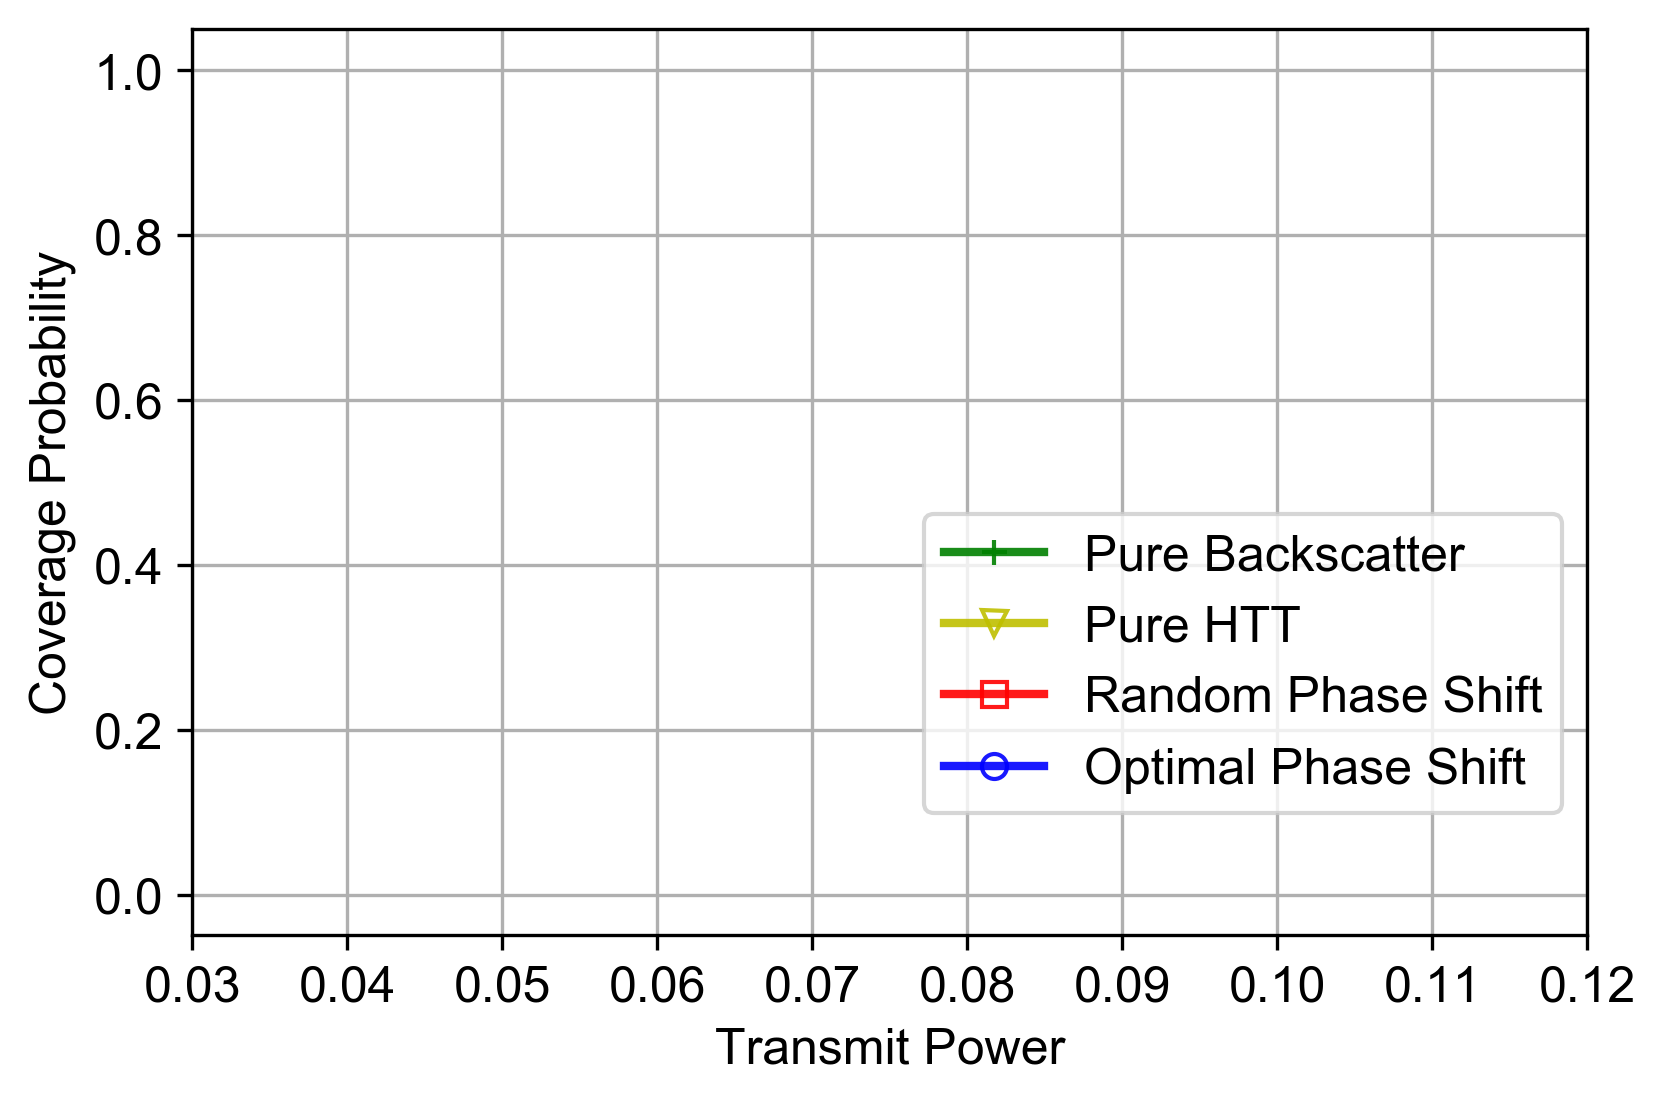

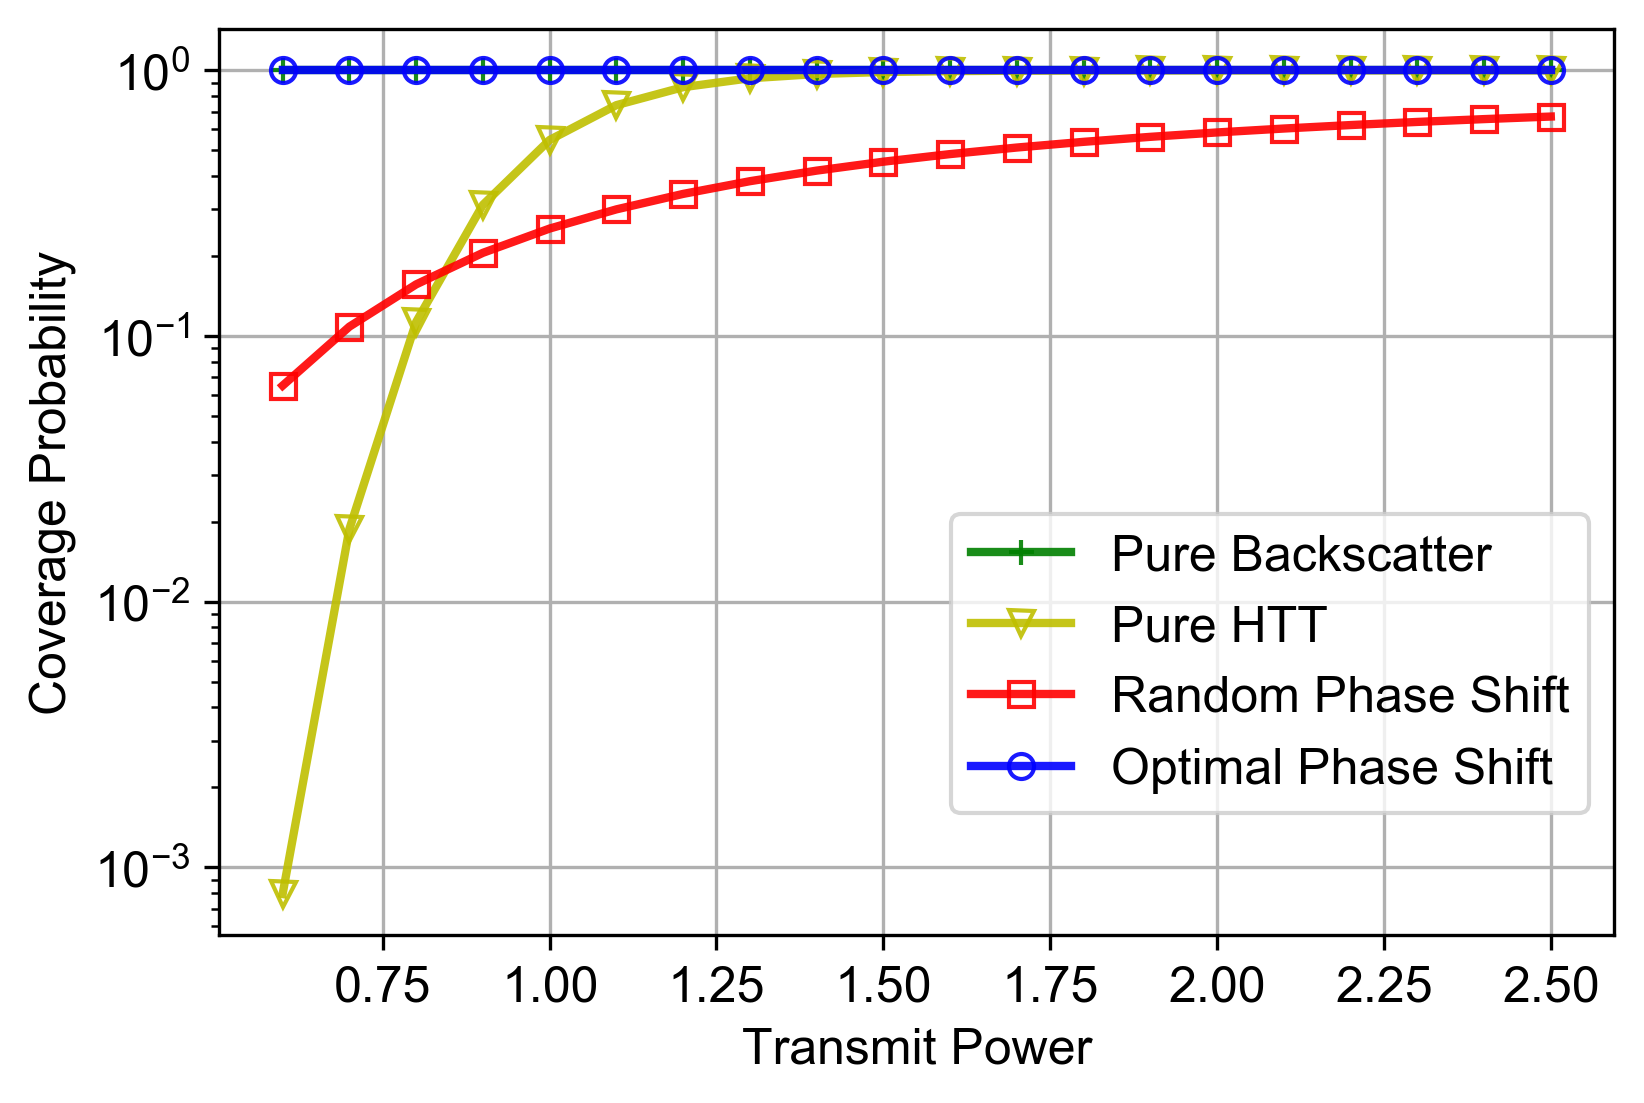

In [163]:
# 数组存储覆盖概率
c_prob_array = []
c_prob_random_array = []
c_prob_pure_a_array = []
c_prob_pure_b_array = []
# 数组存储吞吐量
v_overall_array = []
v_overall_random_array = []
v_b_pure_array = []
v_a_pure_array = []
# 数组存储基站发射功率
pb_array = []

# 接收速率阈值
# R_b = 20 # 
# R_a = 20
R_b = 2.057
R_a = 7.213e-05

CU_b = 8.9e-6 
CU_a = 113e-6 
# CU_b = 8.9e-4
# CU_a = 113e-5

# 数组存储选择 backscatter 模式的概率
prob_mode_array = []
prob_mode_random_array = []

# 初始功率
pb = 0.6

for i in range(20):
    # 非中心参数
    nc = NC(P_l, P_nl)
    nc_random = NC(P_l_random, P_nl_random)
    # backscatter 模式覆盖阈值 （初始阈值 + CDF阈值）
    r_c_b = r_b_coverage(R_b, p_n, eff_b, P_ec, PL_uu, CU_b, E_ec, pb)
    x_c_b = threshold(r_c_b, P_nl)
    x_c_b_random = threshold(r_c_b, P_nl_random) # x_c_a_random 和 x_c_a 相等
    # backscatter 模式覆盖概率 （随机和最优不相等，因为参数 nc 和 nc_random 不同，其余参数相等
    c_b_prob = 1 - ncx2.cdf(x_c_b, df, nc, loc=0, scale=1) # 最优相移中断概率
    c_b_prob_random = 1 - ncx2.cdf(x_c_b_random, df, nc_random, loc=0, scale=1) 
    # HTT 模式覆盖阈值 （初始阈值 + CDF阈值）
    r_c_a = r_htt_coverage(R_a, T_eh, p_n, PL_uu,  CU_a,  E_ec, pb) 
    x_c_a = threshold(r_c_a, P_nl)
    x_c_a_random = threshold(r_c_a, P_nl_random) # x_c_a_random 和 x_c_a 相等
    # HTT 模式覆盖概率
    c_a_prob = 1 - ncx2.cdf(x_c_a, df, nc, loc=0, scale=1) # 最优相移中断概率
    c_a_prob_random = 1 - ncx2.cdf(x_c_a_random, df, nc_random, loc=0, scale=1) 
    # backscatter 模式选择阈值
    r_m = r_mode(CU_a, T_eh, E_ec, eff_b, P_ec, pb)
    x_m = threshold(r_m, P_nl)
    x_m_random = threshold(r_m, P_nl_random) # x_rmode_random 和 x_rmode 是相等的，输入参数都一样 P_nl==P_nl_random
    # backscatter 模式选择概率 (三个条件：1 backscatter模式速率大于HTT 2 信噪比大于阈值 3 电路能启动))
    if x_c_b <= x_m:
        prob_mode = ncx2.cdf(x_m, df, nc, loc=0, scale=1) - ncx2.cdf(x_c_b, df, nc, loc=0, scale=1)
    else:
        prob_mode = 0
    if prob_mode > 1: # 防止概率超过1，导致后面的计算出现负值
        prob_mode =1

    if x_c_b_random <= x_m_random:
        prob_mode_random = ncx2.cdf(x_m_random, df, nc_random, loc=0, scale=1) - ncx2.cdf(x_c_b_random, df, nc, loc=0, scale=1)
    else:
        prob_mode_random = 0
    
    # 最优
    c_prob = prob_mode *  c_b_prob + (1 - prob_mode) * c_a_prob    # 覆盖概率
    c_prob_array.append(c_prob)
    # 随机
    c_prob_random = prob_mode_random * c_b_prob_random + (1 - prob_mode_random) *  c_a_prob_random
    c_prob_random_array.append(c_prob_random)
    # print("xm, xcb, xca = ", x_m, x_c_b, x_c_a)
    # print("mode, c_b, c_a, c, mode_radom = ", prob_mode, c_b_prob, c_a_prob, c_prob, prob_mode_random)
    # 纯后向散射 和 纯HHT 模式下的 覆盖概率
    c_prob_pure_a = c_a_prob
    c_prob_pure_a_array.append(c_prob_pure_a)

    c_prob_pure_b = c_b_prob
    c_prob_pure_b_array.append(c_prob_pure_b)


    pb_array.append(pb)    # 基站发射功率
    # pb = pb + 0.004
    pb = pb + 0.1


# figure(1) 
figure(1, dpi=300)
# plt.title('Coverage probability versus Transmit Power')
plt.plot(pb_array, c_prob_pure_b_array, 'g-', marker='+', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure Backscatter')
plt.plot(pb_array, c_prob_pure_a_array, 'y-', marker='v', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure HTT')
plt.plot(pb_array, c_prob_random_array, 'r-', marker='s', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Random Phase Shift')
plt.plot(pb_array, c_prob_array, 'b-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Optimal Phase Shift')

plt.grid(True)
plt.xlim(0.03, 0.12)
# plt.ylim(0, 1)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.xlabel('Transmit Power', fontsize=12)
plt.ylabel('Coverage Probability', fontsize=12) 
plt.legend(loc='center right', bbox_to_anchor=(1, 0.3), fancybox=True, shadow=False, frameon=True, fontsize=12)

# figure(2) 
figure(2, dpi=300)

semilogy(pb_array, c_prob_pure_b_array, 'g-', marker='+', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure Backscatter')
semilogy(pb_array, c_prob_pure_a_array, 'y-', marker='v', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure HTT')
semilogy(pb_array, c_prob_random_array, 'r-', marker='s', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Random Phase Shift')
semilogy(pb_array, c_prob_array, 'b-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Optimal Phase Shift')

plt.grid(True)
# plt.xlim(1, 8)
# plt.ylim(0.1, 1.02)
plt.tick_params(axis='both',which='major',labelsize=12)
plt.xlabel('Transmit Power', fontsize=12)
plt.ylabel('Coverage Probability', fontsize=12) 
plt.legend(loc='center right', bbox_to_anchor=(1, 0.3), fancybox=True, shadow=False, frameon=True, fontsize=12)

print(c_prob_pure_b_array)
print(c_prob_array)


# 吞吐量 VS 基站发射功率---1w

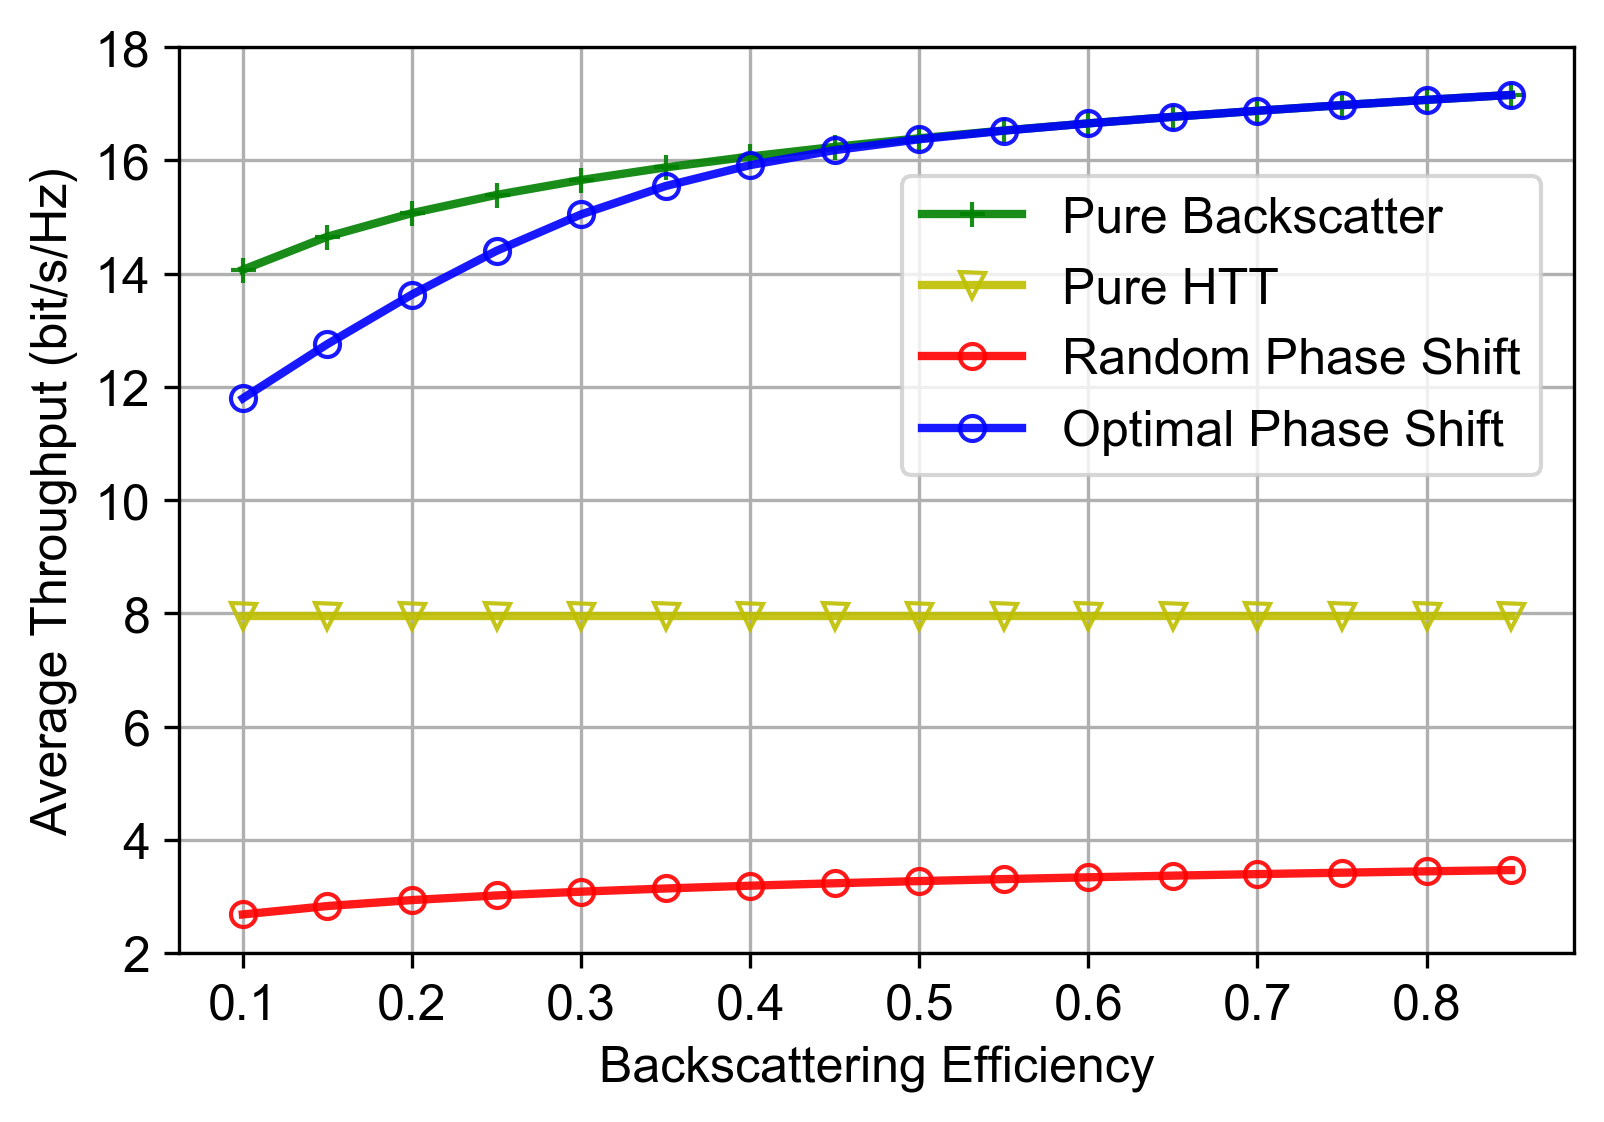

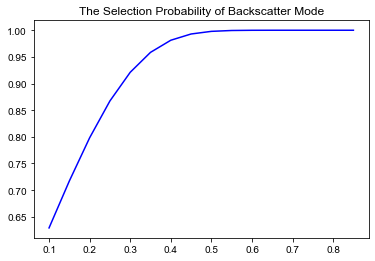

In [166]:
# 传输信噪比
pbsnr = 140 # 默认取值
P_b_SNR = [100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150] # 作变量时的取值
pb = 16 # 传输功率，42dBm (30dBm=1w, +3dBm 功率*2) （基站的发射功率在数十瓦量级）
M_b = N_b = 2 # 均匀矩形阵列（URAS）参数 基站 默认2
M_i = N_i = 8 # 均匀矩形阵列（URAS）参数 IRS 默认8
list_ni = [4, 5, 6, 7, 8, 9, 10, 11, 12] # 作变量时的取值
K_iu = 1 # 默认取值 # 莱斯信道参数
list_kiu = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] # 作变量时的取值
A_bi = 2 # 路径损失系数（该系数越大，信号损失越大）BS-to-IRS
A_iu = 2.5 # 路径损失系数（该系数越大，信号损失越大 IRS-to-user
A_uu = 2 # 路径损失系数（该系数越大，信号损失越大）user-to-user
L_b = [0, 0] # 基站、IRS、用户的位置 单位m，(使用 m，是因为参考论文中使用的m，并给出了响应的计算公式)
L_i = [100, 0] # 基站、IRS、用户的位置 单位m，
L_u1 = [100, 20] # 基站、IRS、用户的位置 单位m，
L_u2 = [100, 30] # 基站、IRS、用户的位置 单位m，
ratio = 0.3333  # URAs 元件之间距离和波长之间的比值 （小于等于1 / 2），用于计算URAs的响应，最优相移不涉及该参数，随机相移的计算会用到
# 离开角、到达角
AoA_h_bi = AoA_v_bi = math.pi / 6
AoD_h_bi = AoD_v_bi = math.pi / 4
AoD_h_iu = AoD_v_iu = math.pi / 3
# 能量捕获过程
E_ec = 0.5 # RF-to-DC 的转化效率，（0.3-0.8)  参考论文默认是0.3
# 后向散射过程
P_ec = 0.625 # 进行能量转换的功率占总功率的比例(0~1) power of energy conversion 0.625
CU_b = 8.9e-6 # circuit threshold of backscatter  后向散射模式的最低电路门限 单位：w。8.9e-6
eff_b = 1 # 后向散射天线系数
R_b = 2.057 # outage rate of backscatter ， 后向散射中断概率 单位 bit/s/Hz，对应信载比门限5dB, 参考论文中只要高于阈值，就以预设的速率接收，预设速率是 1 kbps
# 主动传输过程
T_eh = 0.5 # time of energy harvestHTT模式中，能量捕获的时间占比，在该时间内全部的功率都用来进行能量转换
CU_a = 113e-6 # circuit threshold of active transmission(HTT) 主动传输模式的最低电路门限 单位：w， 113e-6
R_a = 7.213e-05 #4 outage rate of active transmission ， 主动传输中断概率 单位 bit/s/Hz， 对应信噪比门限-40dB
# 噪声
p_n = 9.99e-12 # power of noise 单位； w (=-80dBm)   
B = 1e6 # bandwidth 单位： Hz ，考虑单位带宽的情况，就不需要此项
#####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
# 数组存储覆盖概率
c_prob_array = []
c_prob_random_array = []
c_prob_pure_a_array = []
c_prob_pure_b_array = []
# 数组存储吞吐量（4种方案：提出的最优方案、随机相移方案、纯后向散射、纯HTT）
v_overall_array = [] 
v_overall_random_array = []
v_b_pure_array = []
v_a_pure_array = []

# 数组存储基站发射功率
pb_array = []
# 初始功率
pb = 0.02

# 接收速率阈值
# R_b = 20 # 
# R_a = 20
R_b = 2.057
R_a = 7.213e-05

# 电路启动阈值
CU_b = 8.9e-6 
CU_a = 113e-6 
# CU_b = 8.9e-4
# CU_a = 113e-5



# 数组存储选择 backscatter 模式的概率
prob_mode_array = []
prob_mode_random_array = []

pb = 1 # 在基站发射功率在 1 和 8 的情况下对比 后向散射天线效率的影响
eff_b = 0.1

for i in range(16):
    # 非中心参数
    nc = NC(P_l, P_nl)
    nc_random = NC(P_l_random, P_nl_random)

    # backscatter 模式覆盖阈值 （初始阈值 + CDF阈值）
    r_c_b = r_b_coverage(R_b, p_n, eff_b, P_ec, PL_uu, CU_b, E_ec, pb)
    x_c_b = threshold(r_c_b, P_nl)
    x_c_b_random = threshold(r_c_b, P_nl_random) # x_c_a_random 和 x_c_a 相等

    # backscatter 模式覆盖概率 （随机和最优不相等，因为参数 nc 和 nc_random 不同，其余参数相等
    c_b_prob = 1 - ncx2.cdf(x_c_b, df, nc, loc=0, scale=1) # 最优相移中断概率
    c_b_prob_random = 1 - ncx2.cdf(x_c_b_random, df, nc_random, loc=0, scale=1) 
    # HTT 模式覆盖阈值 （初始阈值 + CDF阈值）
    r_c_a = r_htt_coverage(R_a, T_eh, p_n, PL_uu,  CU_a,  E_ec, pb) 
    x_c_a = threshold(r_c_a, P_nl)
    x_c_a_random = threshold(r_c_a, P_nl_random) # x_c_a_random 和 x_c_a 相等
    # HTT 模式覆盖概率
    c_a_prob = 1 - ncx2.cdf(x_c_a, df, nc, loc=0, scale=1) # 最优相移中断概率
    c_a_prob_random = 1 - ncx2.cdf(x_c_a_random, df, nc_random, loc=0, scale=1) 
    # backscatter 模式选择阈值
    r_m = r_mode(CU_a, T_eh, E_ec, eff_b, P_ec, pb)
    x_m = threshold(r_m, P_nl)
    x_m_random = threshold(r_m, P_nl_random) # x_rmode_random 和 x_rmode 是相等的，输入参数都一样 P_nl==P_nl_random
    # backscatter 模式选择概率 (三个条件：1 backscatter模式速率大于HTT 2 信噪比大于阈值 3 电路能启动))
    if x_c_b <= x_m:
        prob_mode = ncx2.cdf(x_m, df, nc, loc=0, scale=1) - ncx2.cdf(x_c_b, df, nc, loc=0, scale=1)
    else:
        prob_mode = 0
    if prob_mode > 1: # 防止概率超过1，导致后面的计算出现负值
        prob_mode =1

    if x_c_b_random <= x_m_random:
        prob_mode_random = ncx2.cdf(x_m_random, df, nc_random, loc=0, scale=1) - ncx2.cdf(x_c_b_random, df, nc, loc=0, scale=1)
    else:
        prob_mode_random = 0

    prob_mode_array.append(prob_mode)
    prob_mode_random_array.append(prob_mode_random)
    ##################################################################################################################################
    ### 覆盖概率
    c_prob = prob_mode *  c_b_prob + (1 - prob_mode) * c_a_prob    # 覆盖概率
    c_prob_array.append(c_prob)
    c_prob_random = prob_mode_random * c_b_prob_random + (1 - prob_mode_random) *  c_a_prob_random
    c_prob_random_array.append(c_prob_random)
    # print("xm, xcb, xca = ", x_m, x_c_b, x_c_a)
    # print("mode, c_b, c_a, c, mode_radom = ", prob_mode, c_b_prob, c_a_prob, c_prob, prob_mode_random)
    # 纯后向散射 和 纯HHT 模式下的 覆盖概率
    c_prob_pure_a = c_a_prob
    c_prob_pure_a_array.append(c_prob_pure_a)
    c_prob_pure_b = c_b_prob
    c_prob_pure_b_array.append(c_prob_pure_b)
    ##################################################################################################################################
    ### 吞吐量
    f = lambda x:log2(1 + (eff_b * (1 - P_ec) * pb * PL_uu * x * P_nl / 2) / p_n) * ncx2.pdf(x, df, nc)# 平均吞吐量 最优相移 （使用积分计算）
    v_b_temp_0 = integrate.quad(f, x_c_b, np.inf)
    v_b =  v_b_temp_0[0]
    g = lambda y:log2(1 + ((T_eh * E_ec * pb * PL_uu) * y * P_nl / 2 - CU_a * PL_uu) / ((1 - T_eh) * p_n)) * ncx2.pdf(y, df, nc)
    v_a_temp_0 = integrate.quad(g, x_c_a, np.inf)
    v_a = v_a_temp_0[0]
    v_overall = prob_mode * v_b + (1 - prob_mode) * v_a
    v_overall_array.append(v_overall)
    
    f_random = lambda x:log2(1 + (eff_b * (1 - P_ec) * pb * PL_uu * x * P_nl / 2) / p_n) * ncx2.pdf(x, df, nc_random) # 平均吞吐量 随机相移
    v_b_temp_0_random = integrate.quad(f_random, x_c_b_random, np.inf)
    v_b_random =  v_b_temp_0_random[0]
    g_random = lambda y:(1 - T_eh) * log2(1 + ((T_eh * E_ec * pb * PL_uu) * y * P_nl / 2 - CU_a * PL_uu) / ((1 - T_eh) * p_n)) * ncx2.pdf(y, df, nc_random)
    v_a_temp_0_random = integrate.quad(g_random, x_c_a_random, np.inf)
    v_a_random = v_a_temp_0_random[0]
    v_overall_random = prob_mode_random * v_b_random + (1 - prob_mode_random) * v_a_random
    v_overall_random_array.append(v_overall_random)
    
    v_b_pure = v_b # 平均吞吐量 单一模式
    v_b_pure_array.append(v_b_pure)
    v_a_pure = v_a
    v_a_pure_array.append(v_a_pure)

    pb_array.append(eff_b)    # 基站发射功率
    eff_b = eff_b + 0.05




figure(2, dpi=300)
# plt.title('Average Throughput versus Backscattering Efficiency')
plt.plot(pb_array, v_b_pure_array, 'g-', marker='+', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure Backscatter')
plt.plot(pb_array, v_a_pure_array, 'y-', marker='v', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure HTT')
plt.plot(pb_array, v_overall_random_array, 'r-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Random Phase Shift')
plt.plot(pb_array, v_overall_array, 'b-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Optimal Phase Shift')

plt.grid(True)
# plt.xlim(0.1, 0.85)
plt.ylim(2, 18)
plt.tick_params(axis='both',which='major',labelsize=12)

plt.xlabel('Backscattering Efficiency',fontsize=12)
plt.ylabel('Average Throughput (bit/s/Hz)', fontsize=12)
plt.legend(loc='best', bbox_to_anchor=(0.5, 0.5),fancybox=True, shadow=False, frameon=True, fontsize=12)

figure(3)
plt.title('The Selection Probability of Backscatter Mode')
plt.plot(pb_array, prob_mode_array, 'b')
# plt.plot(pb_array, prob_mode_random_array, 'r')

# 吞吐量 VS 基站发射功率---8w

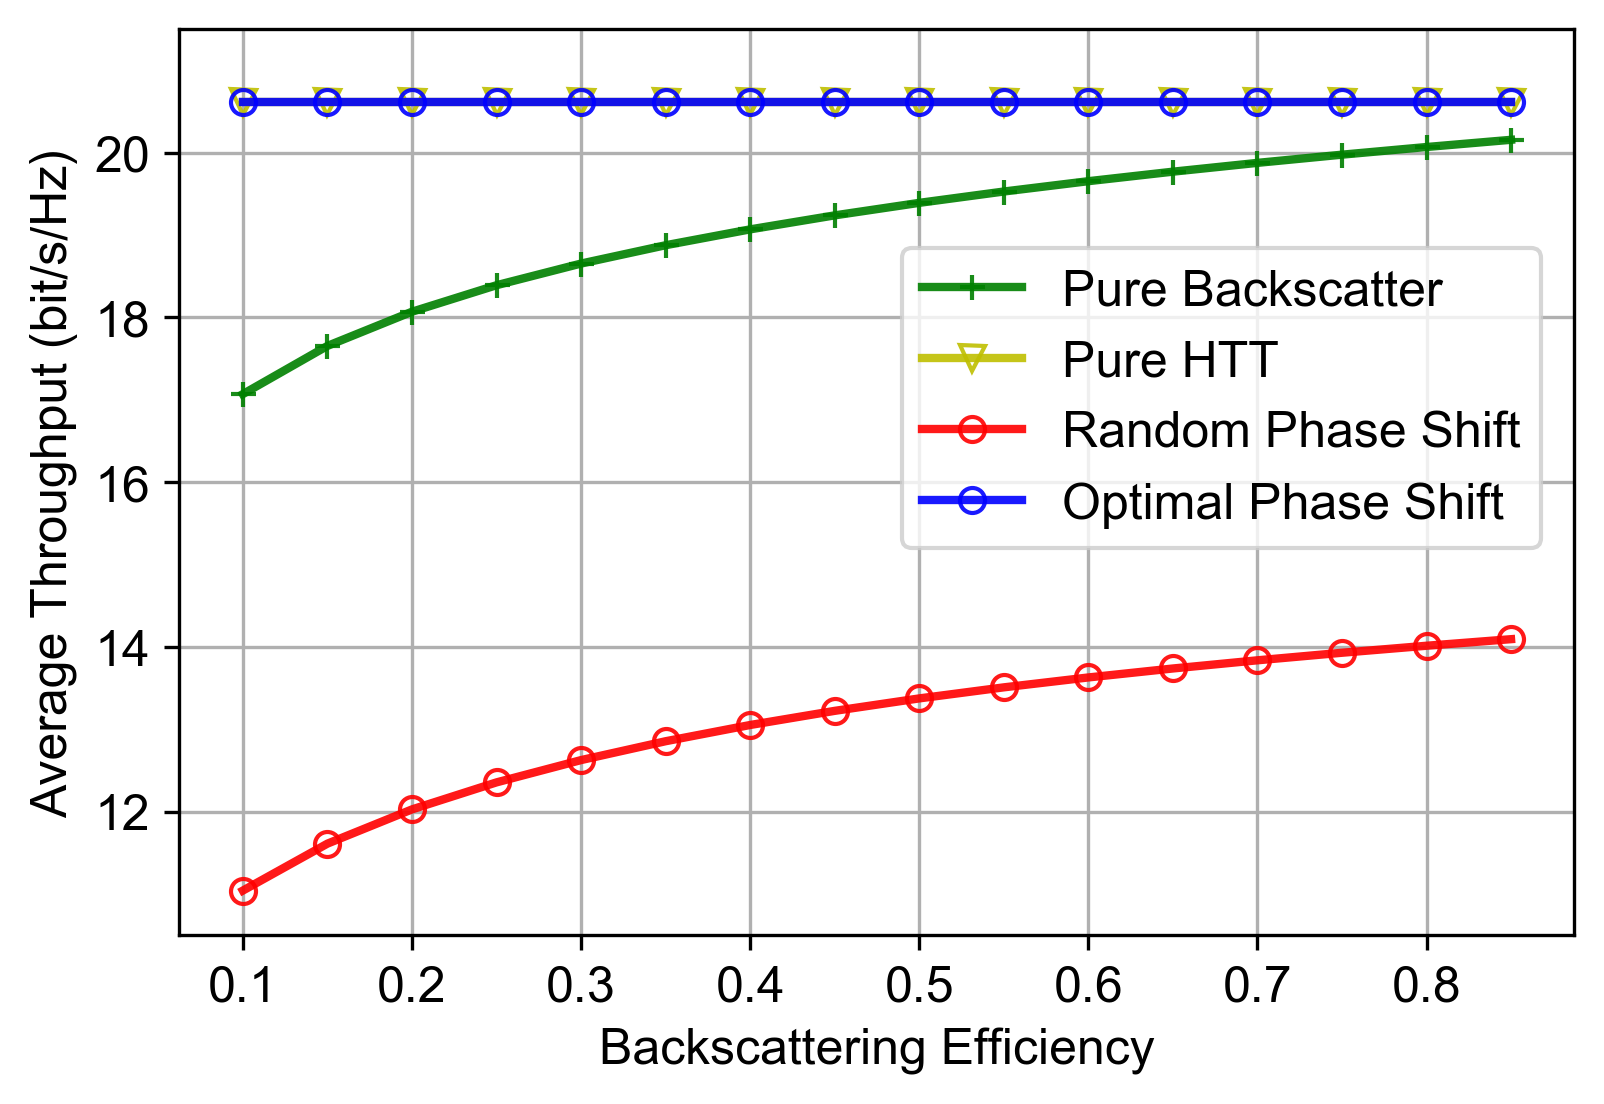

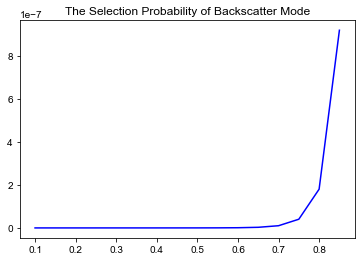

In [170]:
# 传输信噪比
pbsnr = 140 # 默认取值
P_b_SNR = [100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150] # 作变量时的取值
pb = 16 # 传输功率，42dBm (30dBm=1w, +3dBm 功率*2) （基站的发射功率在数十瓦量级）
M_b = N_b = 2 # 均匀矩形阵列（URAS）参数 基站 默认2
M_i = N_i = 8 # 均匀矩形阵列（URAS）参数 IRS 默认8
list_ni = [4, 5, 6, 7, 8, 9, 10, 11, 12] # 作变量时的取值
K_iu = 1 # 默认取值 # 莱斯信道参数
list_kiu = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] # 作变量时的取值
A_bi = 2 # 路径损失系数（该系数越大，信号损失越大）BS-to-IRS
A_iu = 2.5 # 路径损失系数（该系数越大，信号损失越大 IRS-to-user
A_uu = 2 # 路径损失系数（该系数越大，信号损失越大）user-to-user
L_b = [0, 0] # 基站、IRS、用户的位置 单位m，(使用 m，是因为参考论文中使用的m，并给出了响应的计算公式)
L_i = [100, 0] # 基站、IRS、用户的位置 单位m，
L_u1 = [100, 20] # 基站、IRS、用户的位置 单位m，
L_u2 = [100, 30] # 基站、IRS、用户的位置 单位m，
ratio = 0.3333  # URAs 元件之间距离和波长之间的比值 （小于等于1 / 2），用于计算URAs的响应，最优相移不涉及该参数，随机相移的计算会用到
# 离开角、到达角
AoA_h_bi = AoA_v_bi = math.pi / 6
AoD_h_bi = AoD_v_bi = math.pi / 4
AoD_h_iu = AoD_v_iu = math.pi / 3
# 能量捕获过程
E_ec = 0.5 # RF-to-DC 的转化效率，（0.3-0.8)  参考论文默认是0.3
# 后向散射过程
P_ec = 0.625 # 进行能量转换的功率占总功率的比例(0~1) power of energy conversion 0.625
CU_b = 8.9e-6 # circuit threshold of backscatter  后向散射模式的最低电路门限 单位：w。8.9e-6
eff_b = 1 # 后向散射天线系数
R_b = 2.057 # outage rate of backscatter ， 后向散射中断概率 单位 bit/s/Hz，对应信载比门限5dB, 参考论文中只要高于阈值，就以预设的速率接收，预设速率是 1 kbps
# 主动传输过程
T_eh = 0.5 # time of energy harvestHTT模式中，能量捕获的时间占比，在该时间内全部的功率都用来进行能量转换
CU_a = 113e-6 # circuit threshold of active transmission(HTT) 主动传输模式的最低电路门限 单位：w， 113e-6
R_a = 7.213e-05 #4 outage rate of active transmission ， 主动传输中断概率 单位 bit/s/Hz， 对应信噪比门限-40dB
# 噪声
p_n = 9.99e-12 # power of noise 单位； w (=-80dBm)   
B = 1e6 # bandwidth 单位： Hz ，考虑单位带宽的情况，就不需要此项
#####################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################
# 数组存储覆盖概率
c_prob_array = []
c_prob_random_array = []
c_prob_pure_a_array = []
c_prob_pure_b_array = []
# 数组存储吞吐量（4种方案：提出的最优方案、随机相移方案、纯后向散射、纯HTT）
v_overall_array = [] 
v_overall_random_array = []
v_b_pure_array = []
v_a_pure_array = []

# 数组存储基站发射功率
pb_array = []
# 初始功率
pb = 0.02

# 接收速率阈值
# R_b = 20 # 
# R_a = 20
R_b = 2.057
R_a = 7.213e-05

# 电路启动阈值
CU_b = 8.9e-6 
CU_a = 113e-6 
# CU_b = 8.9e-4
# CU_a = 113e-5



# 数组存储选择 backscatter 模式的概率
prob_mode_array = []
prob_mode_random_array = []

pb = 8 # 在基站发射功率在 1 和 8 的情况下对比 后向散射天线效率的影响
eff_b = 0.1

for i in range(16):
    # 非中心参数
    nc = NC(P_l, P_nl)
    nc_random = NC(P_l_random, P_nl_random)

    # backscatter 模式覆盖阈值 （初始阈值 + CDF阈值）
    r_c_b = r_b_coverage(R_b, p_n, eff_b, P_ec, PL_uu, CU_b, E_ec, pb)
    x_c_b = threshold(r_c_b, P_nl)
    x_c_b_random = threshold(r_c_b, P_nl_random) # x_c_a_random 和 x_c_a 相等

    # backscatter 模式覆盖概率 （随机和最优不相等，因为参数 nc 和 nc_random 不同，其余参数相等
    c_b_prob = 1 - ncx2.cdf(x_c_b, df, nc, loc=0, scale=1) # 最优相移中断概率
    c_b_prob_random = 1 - ncx2.cdf(x_c_b_random, df, nc_random, loc=0, scale=1) 
    # HTT 模式覆盖阈值 （初始阈值 + CDF阈值）
    r_c_a = r_htt_coverage(R_a, T_eh, p_n, PL_uu,  CU_a,  E_ec, pb) 
    x_c_a = threshold(r_c_a, P_nl)
    x_c_a_random = threshold(r_c_a, P_nl_random) # x_c_a_random 和 x_c_a 相等
    # HTT 模式覆盖概率
    c_a_prob = 1 - ncx2.cdf(x_c_a, df, nc, loc=0, scale=1) # 最优相移中断概率
    c_a_prob_random = 1 - ncx2.cdf(x_c_a_random, df, nc_random, loc=0, scale=1) 
    # backscatter 模式选择阈值
    r_m = r_mode(CU_a, T_eh, E_ec, eff_b, P_ec, pb)
    x_m = threshold(r_m, P_nl)
    x_m_random = threshold(r_m, P_nl_random) # x_rmode_random 和 x_rmode 是相等的，输入参数都一样 P_nl==P_nl_random
    # backscatter 模式选择概率 (三个条件：1 backscatter模式速率大于HTT 2 信噪比大于阈值 3 电路能启动))
    if x_c_b <= x_m:
        prob_mode = ncx2.cdf(x_m, df, nc, loc=0, scale=1) - ncx2.cdf(x_c_b, df, nc, loc=0, scale=1)
    else:
        prob_mode = 0
    if prob_mode > 1: # 防止概率超过1，导致后面的计算出现负值
        prob_mode =1

    if x_c_b_random <= x_m_random:
        prob_mode_random = ncx2.cdf(x_m_random, df, nc_random, loc=0, scale=1) - ncx2.cdf(x_c_b_random, df, nc, loc=0, scale=1)
    else:
        prob_mode_random = 0

    prob_mode_array.append(prob_mode)
    prob_mode_random_array.append(prob_mode_random)
    ##################################################################################################################################
    ### 覆盖概率
    c_prob = prob_mode *  c_b_prob + (1 - prob_mode) * c_a_prob    # 覆盖概率
    c_prob_array.append(c_prob)
    c_prob_random = prob_mode_random * c_b_prob_random + (1 - prob_mode_random) *  c_a_prob_random
    c_prob_random_array.append(c_prob_random)
    # print("xm, xcb, xca = ", x_m, x_c_b, x_c_a)
    # print("mode, c_b, c_a, c, mode_radom = ", prob_mode, c_b_prob, c_a_prob, c_prob, prob_mode_random)
    # 纯后向散射 和 纯HHT 模式下的 覆盖概率
    c_prob_pure_a = c_a_prob
    c_prob_pure_a_array.append(c_prob_pure_a)
    c_prob_pure_b = c_b_prob
    c_prob_pure_b_array.append(c_prob_pure_b)
    ##################################################################################################################################
    ### 吞吐量
    f = lambda x:log2(1 + (eff_b * (1 - P_ec) * pb * PL_uu * x * P_nl / 2) / p_n) * ncx2.pdf(x, df, nc)# 平均吞吐量 最优相移 （使用积分计算）
    v_b_temp_0 = integrate.quad(f, x_c_b, np.inf)
    v_b =  v_b_temp_0[0]
    g = lambda y:log2(1 + ((T_eh * E_ec * pb * PL_uu) * y * P_nl / 2 - CU_a * PL_uu) / ((1 - T_eh) * p_n)) * ncx2.pdf(y, df, nc)
    v_a_temp_0 = integrate.quad(g, x_c_a, np.inf)
    v_a = v_a_temp_0[0]
    v_overall = prob_mode * v_b + (1 - prob_mode) * v_a
    v_overall_array.append(v_overall)
    
    f_random = lambda x:log2(1 + (eff_b * (1 - P_ec) * pb * PL_uu * x * P_nl / 2) / p_n) * ncx2.pdf(x, df, nc_random) # 平均吞吐量 随机相移
    v_b_temp_0_random = integrate.quad(f_random, x_c_b_random, np.inf)
    v_b_random =  v_b_temp_0_random[0]
    g_random = lambda y:(1 - T_eh) * log2(1 + ((T_eh * E_ec * pb * PL_uu) * y * P_nl / 2 - CU_a * PL_uu) / ((1 - T_eh) * p_n)) * ncx2.pdf(y, df, nc_random)
    v_a_temp_0_random = integrate.quad(g_random, x_c_a_random, np.inf)
    v_a_random = v_a_temp_0_random[0]
    v_overall_random = prob_mode_random * v_b_random + (1 - prob_mode_random) * v_a_random
    v_overall_random_array.append(v_overall_random)
    
    v_b_pure = v_b # 平均吞吐量 单一模式
    v_b_pure_array.append(v_b_pure)
    v_a_pure = v_a
    v_a_pure_array.append(v_a_pure)

    pb_array.append(eff_b)    # 基站发射功率
    eff_b = eff_b + 0.05


# figure(1) #figure(1, dpi=300)
# plt.title('Coverage probability versus Transmit Power')
# plt.plot(pb_array, c_prob_array, 'b-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1, label='Optimal phrase shifts')
# plt.plot(pb_array, c_prob_random_array, 'r-', marker='s', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1, label='Random phrase shifts')
# plt.plot(pb_array, c_prob_pure_a_array, 'y-', marker='v', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1, label='Pure HTT')
# plt.plot(pb_array, c_prob_pure_b_array, 'g-', marker='+', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=1, label='Pure Backscatter')
# plt.xlabel('Transmit Power')
# plt.ylabel('Coverage Probability') 
# plt.legend(loc='center right', bbox_to_anchor=(1, 0.3), fancybox=True, shadow=False, frameon=True)


figure(2, dpi=300)
# plt.title('Average Throughput versus Backscattering Efficiency')
plt.plot(pb_array, v_b_pure_array, 'g-', marker='+', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure Backscatter')
plt.plot(pb_array, v_a_pure_array, 'y-', marker='v', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Pure HTT')
plt.plot(pb_array, v_overall_random_array, 'r-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Random Phase Shift')
plt.plot(pb_array, v_overall_array, 'b-', marker='o', markerfacecolor='none', markeredgewidth=1, lw=2, alpha=0.9, label='Optimal Phase Shift')
plt.grid(True)
# plt.xlim(0.1, 0.85)
plt.ylim(10.5, 21.5)
plt.tick_params(axis='both',which='major',labelsize=12)

plt.xlabel('Backscattering Efficiency',fontsize=12)
plt.ylabel('Average Throughput (bit/s/Hz)', fontsize=12)
plt.legend(loc='best', bbox_to_anchor=(0.5, 0.4),fancybox=True, shadow=False, frameon=True, fontsize=12)


figure(3)
plt.title('The Selection Probability of Backscatter Mode')
plt.plot(pb_array, prob_mode_array, 'b')
# plt.plot(pb_array, prob_mode_random_array, 'r')

In [25]:
print(CU_a / ((T_eh * E_ec -  eff_b * (1 - T_eh) * (1 - P_ec)) * (7)))

0.00019868131868131875


0.0 inf


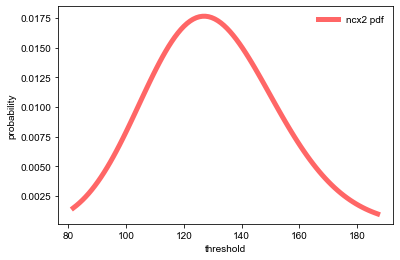

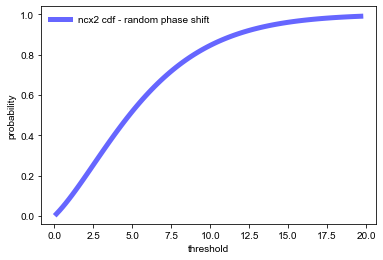

In [26]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(ncx2.ppf(0.01, df, nc), ncx2.ppf(0.99, df, nc), 100)
ax.plot(x, ncx2.pdf(x, df, nc), 'r-', lw=5, alpha=0.6, label='ncx2 pdf')
# ax.plot(x, ncx2.cdf(x, df, nc, loc=0, scale=1), 'b-', lw=5, alpha=0.6, label='ncx2 cdf - optimal phase shift')
plt.xlabel('threshold')
plt.ylabel('probability')
ax.legend(loc='best', frameon=False)
print(ncx2.ppf(0, df, nc), ncx2.ppf(1, df, nc))

fig, ax = plt.subplots(1, 1)
x = np.linspace(ncx2.ppf(0.01, df, nc_random), ncx2.ppf(0.99, df, nc_random), 100)
# ax.plot(x, ncx2.pdf(x, df, nc), 'r-', lw=5, alpha=0.6, label='ncx2 pdf')
ax.plot(x, ncx2.cdf(x, df, nc_random, loc=0, scale=1), 'b-', lw=5, alpha=0.6, label='ncx2 cdf - random phase shift')
plt.xlabel('threshold')
plt.ylabel('probability')
ax.legend(loc='best', frameon=False)

In [27]:

f = lambda x:ncx2.pdf(x, 2, 128)
i = integrate.quad(f, 128, np.inf)
print(i[0])
a=1
f = lambda x: log2(x) * sin(x) * cos(x)
i = integrate.quad(f, 10, np.inf)
print(i[0])

0.5176482184725183
-7035152.650901764


## 平均吞吐量

In [28]:
v_b_temp_1 = eff_b * (1 - P_ec) * pb * PL_uu  / p_n
print(v_b_temp_1)

2702702702.7027035


In [29]:
# 将参考论文中的信噪比门限换算为速率
# 0.5log2(1+10^(-40/10)) HTT -40dB
# log2(1+10^(5/10)) backscatter 5dB
print(pow(10, (-40/10)), 0.5 * log2(1 + pow(10, (-40/10))))
print(pow(10, (5 / 10)), log2(1 + pow(10, (5 / 10))))
# print(pow(9, (1/4)))


0.0001 7.213114554726915e-05
3.1622776601683795 2.057373208606795


24.001957897215572
12.13034608280787


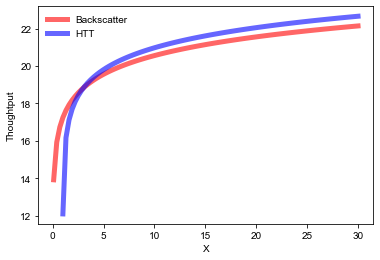

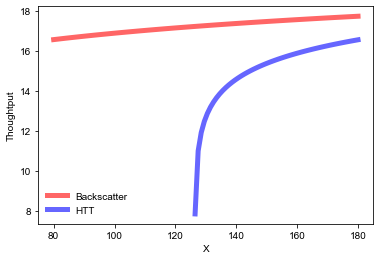

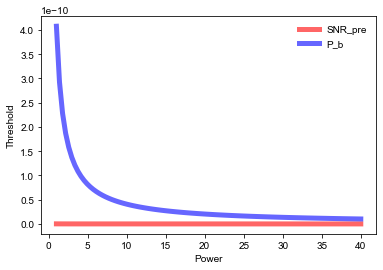

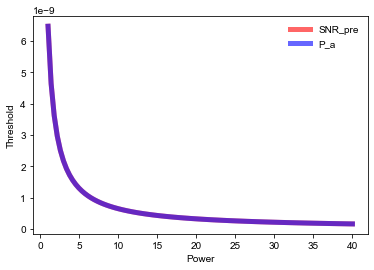

In [30]:
print(log2(168 * 10e4))
print(0.5 * log2(201 * 10e4))
fig, ax = plt.subplots(1, 1)
x = np.linspace(0.1, 30, 100)
ax.plot(x, log2(1 + (eff_b * (1 - P_ec) * x * PL_uu * 128 * P_nl / 2) / p_n), 'r-', lw=5, alpha=0.6, label='Backscatter')
ax.plot(x, log2(1 + ((T_eh * E_ec * x * PL_uu) * 128 * P_nl / 2 - CU_a * PL_uu) / ((1 - T_eh) * p_n)), 'b-', lw=5, alpha=0.6, label='HTT')
plt.xlabel('X')
plt.ylabel('Thoughtput')
ax.legend(loc='best', frameon=False)

fig, ax = plt.subplots(1, 1)
x = np.linspace(80, 180, 100)
ax.plot(x, log2(1 + (eff_b * (1 - P_ec) * 1 * PL_uu * x * P_nl / 2) / p_n), 'r-', lw=5, alpha=0.6, label='Backscatter')
ax.plot(x, log2(1 + ((T_eh * E_ec * 1 * PL_uu) * x * P_nl / 2 - CU_a * PL_uu) / ((1 - T_eh) * p_n)), 'b-', lw=5, alpha=0.6, label='HTT')
plt.xlabel('X')
plt.ylabel('Thoughtput')
ax.legend(loc='best', frameon=False)

fig, ax = plt.subplots(1, 1)
x = np.linspace(1, 40, 100)
ax.plot(x, (2 * P_nl) * ((pow(2, R_b) - 1) * p_n) / (eff_b * (1 - P_ec) * x * PL_uu), 'r-', lw=5, alpha=0.6, label='SNR_pre')
ax.plot(x, (2 * P_nl) * CU_b / (P_ec * E_ec * x), 'b-', lw=5, alpha=0.6, label='P_b')
plt.xlabel('Power')
plt.ylabel('Threshold')
ax.legend(loc='best', frameon=False)

fig, ax = plt.subplots(1, 1)
x = np.linspace(1, 40, 100)
ax.plot(x, (2 * P_nl) * ((pow(2, R_a) - 1) * (1 - T_eh) * p_n + CU_a * PL_uu ) / (T_eh * E_ec * x * PL_uu), 'r-', lw=5, alpha=0.6, label='SNR_pre')
ax.plot(x, (2 * P_nl) * CU_a / (T_eh * E_ec * x), 'b-', lw=5, alpha=0.6, label='P_a')
plt.xlabel('Power')
plt.ylabel('Threshold')
ax.legend(loc='best', frameon=False)

In [31]:
print("1", "\n", "2")

1 
 2


In [125]:
eq1 = [1,2]
eq2 = [3,4]
eq = np.concatenate((eq1, eq2), axis=0)
print(eq1)
print(eq2)
print(eq)
print(len(eq))

[1, 2]
[3, 4]
[1 2 3 4]
4
